In [1]:
from time import time

notebook_start_time = time()

#Only Uncomment When Committing

# Directory Setup

In [2]:
tr_dir_base = "/kaggle/input/labeled-chest-xray-images/chest_xray/train/"
ts_dir_base = "/kaggle/input/labeled-chest-xray-images/chest_xray/test/"

tr_dir_normal = tr_dir_base + "NORMAL/"
ts_dir_normal = ts_dir_base + "NORMAL/"

tr_dir_pnemon = tr_dir_base + "PNEUMONIA/"
ts_dir_pnemon = ts_dir_base + "PNEUMONIA/"

# Library Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.image as img
from PIL import Image
import cv2

import torch
from torch import optim, nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as DL
from torch.nn.utils import weight_norm as WN
import torch.optim.lr_scheduler as LR
import torch.nn.functional as F

from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, log_loss, f1_score
from sklearn.model_selection import KFold

import random as r
import os
from time import time

MAX_VALUE = 255

# Helper Functions

In [4]:
def breaker():
    print("\n" + 30*"-" + "\n")
    
def head(x, no_of_ele=5):
    breaker()
    print(x[:no_of_ele])
    breaker()

def getFileNames(root_dir=None):
    f_name = []
    for dirname, _, filenames in os.walk(root_dir):
        for filename in filenames:
            f_name.append(filename)
    return f_name

def removeChannelInfo(file_path=None, file_names=None, size=None):
    sizes = []
    images = []
    for name in file_names:
        image = cv2.imread(file_path+name)
        if len(image.shape) > 2:
            image = image[:, :, -1]
        sizes.append(image.shape)
        images.append(cv2.resize(image, dsize=(size, size), interpolation=cv2.INTER_LANCZOS4))
    return images, sizes

# Data Processing

**File Name Handling**

In [5]:
tr_normal_file_names = getFileNames(tr_dir_normal)
tr_pnemon_file_names = getFileNames(tr_dir_pnemon)
ts_normal_file_names = getFileNames(ts_dir_normal)
ts_pnemon_file_names = getFileNames(ts_dir_pnemon)

**Basic Info (Used to confirm correctness Pre-Dataset Numpy Arrays)**

In [6]:
breaker()
print("Total Training Set Size        :", repr(len(tr_normal_file_names) + len(tr_pnemon_file_names)))
breaker()
print("Total Test Set Size            :", repr(len(ts_normal_file_names) + len(ts_pnemon_file_names)))
breaker()


------------------------------

Total Training Set Size        : 5232

------------------------------

Total Test Set Size            : 624

------------------------------



**Reading Image Data**

In [7]:
start_time = time()

n_size = 127
trn_images, trn_sizes = removeChannelInfo(tr_dir_normal, tr_normal_file_names, n_size)
trp_images, trp_sizes = removeChannelInfo(tr_dir_pnemon, tr_pnemon_file_names, n_size)

tsn_images, tsn_sizes = removeChannelInfo(ts_dir_normal, ts_normal_file_names, n_size)
tsp_images, tsp_sizes = removeChannelInfo(ts_dir_pnemon, ts_pnemon_file_names, n_size)

print("Time Taken to process data : {:.2f} minutes".format((time()-start_time)/60))

Time Taken to process data : 2.05 minutes


**Consolidating Train Images and creating Labels**

In [8]:
tr_images = np.concatenate((trn_images, trp_images), axis=0)
tr_images = np.divide(tr_images, MAX_VALUE)
tr_labels = np.concatenate((np.zeros((len(trn_images))), np.ones((len(trp_images)))), axis=0)

print(tr_images.shape)
print(tr_labels.shape)

(5232, 127, 127)
(5232,)


**Consolidating Test Images and creating Labels**

In [9]:
ts_images = np.concatenate((tsn_images, tsp_images), axis=0)
ts_images = np.divide(ts_images, MAX_VALUE)
ts_labels = np.concatenate((np.zeros((len(tsn_images))), np.ones((len(tsp_images)))), axis=0)

print(ts_images.shape)
print(ts_labels.shape)

num_obs_test = ts_labels.shape[0]

(624, 127, 127)
(624,)


**Dataset Template**

In [10]:
class DS(Dataset):
    def __init__(this, X=None, y=None, mode="train"):
        this.mode = mode
        this.X = X
        if mode == "train":
            this.y = y
        
    def __len__(this):
        return this.X.shape[0]
    
    def __getitem__(this, idx):
        if this.mode == "train":
            return torch.FloatTensor(this.X[idx]), torch.FloatTensor(this.y[idx])
        else:
            return torch.FloatTensor(this.X[idx])

# ANN

**Config**

In [11]:
class ANN_CFG():
    tr_batch_size = 128
    ts_batch_size = 128
    
    epochs = 25
    
    HL = [2048, 2048, 2048]
    OL = 1
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
cfg = ANN_CFG()

trds = DS(tr_images, tr_labels.reshape(-1,1))
trd  = DL(trds, batch_size=cfg.tr_batch_size, shuffle=True, generator=torch.manual_seed(0))

**Setup**

In [12]:
class ANN(nn.Module):
    def __init__(this, IL=None, HL=None, OL=None):
    
        super(ANN, this).__init__()
        
        this.MP  = nn.MaxPool2d(kernel_size=2)
        this.DP  = nn.Dropout(p=0.3)
    
        this.BN1 = nn.BatchNorm2d(1)
        this.CN1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3)
        
        this.BN2 = nn.BatchNorm2d(64)
        this.CN2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        
        this.BN3 = nn.BatchNorm2d(64)
        this.CN3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        
        this.BN4 = nn.BatchNorm2d(128)
        this.CN4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3)
        
        this.BN5 = nn.BatchNorm2d(128)
        this.CN5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3)
        
        this.FC1 = WN(nn.Linear(128*2*2, HL[0]))
        this.FC2 = WN(nn.Linear(HL[0], HL[1]))
        this.FC3 = WN(nn.Linear(HL[1], OL))
        
    def getOptimizer(this):
        return optim.Adam(this.parameters(), lr=1e-3, weight_decay=0)
    
    def forward(this, x):
        x = this.BN1(x)
        x = this.CN1(x)
        x = F.relu(this.MP(x))
        
        x = this.BN2(x)
        x = this.CN2(x)
        x = F.relu(this.MP(x))
        
        x = this.BN3(x)
        x = this.CN3(x)
        x = F.relu(this.MP(x))
        
        x = this.BN4(x)
        x = this.CN4(x)
        x = F.relu(this.MP(x))
        
        x = this.BN5(x)
        x = this.CN5(x)
        x = F.relu(this.MP(x))
        
        x = x.view(x.shape[0], -1)
        
        x = F.relu(this.FC1(x))
        x = F.relu(this.FC2(x))
        x = torch.sigmoid(this.FC3(x))
        return x

**Debugging Sizes**

In [13]:
#net = ANN(IL=None, HL=cfg.HL, OL=cfg.OL)
#net.to(cfg.device)
#net.train()

#trds = DS(tr_images, tr_labels.reshape(-1,1))
#trd = DL(trds, batch_size=128, shuffle=False)

#xxxx, yyyy = next(iter(trd))

#op = net(xxxx.to(cfg.device).view(xxxx.shape[0], 1, n_size, n_size))
#print(op.shape)

#del trds, trd, xxxx, yyyy, op, net

**ANN Helpers**

In [14]:
def train_fn(X=None, y=None):
    LP = []
    name_getter = []
    
    bestLoss = {"train" : np.inf, "valid" : np.inf}
    
    n_folds = 4
    fold = 0
    
    start_time = time()
    for tr_idx, va_idx in KFold(n_splits=n_folds, shuffle=True, random_state=0).split(X, y):
        breaker()
        print("Fold {fold} processing...".format(fold=fold+1))
        
        X_train, X_valid, y_train, y_valid = X[tr_idx], X[va_idx], y[tr_idx], y[va_idx]
        
        tr_data_setup = DS(X_train, y_train.reshape(-1,1))
        va_data_setup = DS(X_valid, y_valid.reshape(-1,1))
        
        dataloaders = {"train" : DL(tr_data_setup, batch_size=cfg.tr_batch_size, shuffle=True, generator=torch.manual_seed(0)),
                       "valid" : DL(va_data_setup, batch_size=cfg.tr_batch_size, shuffle=False)}
        
        model = ANN(IL=None, HL=cfg.HL, OL=cfg.OL)
        model.to(cfg.device)
        
        optimizer = model.getOptimizer()
        
        for e in range(cfg.epochs):
            epochLoss = {"train" : 0, "valid" : 0}
            for phase in ["train", "valid"]:
                if phase == "train":
                    model.train()
                else:
                    model.eval()
                lossPerPass = 0
                
                for feats, label in dataloaders[phase]:
                    feats, label = feats.to(cfg.device).view(feats.shape[0], 1, n_size, n_size), label.to(cfg.device)
                    
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase == "train"):
                        output = model(feats)
                        loss = nn.BCELoss()(output, label)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                    lossPerPass += (loss.item()/label.shape[0])
                epochLoss[phase] = lossPerPass
            LP.append(epochLoss)
            
            if epochLoss["valid"] < bestLoss["valid"]:
                bestLoss = epochLoss
                name = "./Model_Fold_{fold}.pt".format(fold=fold)
                name_getter.append(name)
                torch.save(model.state_dict(), name)
        fold += 1
    
    breaker()
    print("Time taken to train {fold} folds for {e} epochs : {:.2f} minutes".format((time()-start_time)/60, fold=n_folds, e=cfg.epochs))
    breaker()
    print("Best Loss :", repr(bestLoss))
    breaker()
    
    return LP, name_getter, model

def eval_fn(model=None, names=None, dataloader=None):
    final_Pred = np.zeros((num_obs_test, 1))
    
    for name in names:
        Pred = torch.zeros(cfg.ts_batch_size, 1).to(cfg.device)
        model.load_state_dict(torch.load(name))
        model.eval()
        for X, y in dataloader:
            X = X.to(cfg.device).view(X.shape[0], 1, n_size, n_size)
            with torch.no_grad():
                Prob = model(X)
            Pred = torch.cat((Pred, Prob), dim=0)
        Pred = Pred[cfg.ts_batch_size:]
        Pred = Pred.cpu().numpy()
        final_Pred = np.add(final_Pred, Pred)
        
    final_Pred = np.divide(final_Pred, len(names))
    final_Pred[np.argwhere(final_Pred > 0.5)[:, 0]]  = int(1)
    final_Pred[np.argwhere(final_Pred <= 0.5)[:, 0]] = int(0)
    return final_Pred.reshape(-1)

In [15]:
LP, Names, Network = train_fn(X=tr_images, y=tr_labels)


------------------------------

Fold 1 processing...

------------------------------

Fold 2 processing...

------------------------------

Fold 3 processing...

------------------------------

Fold 4 processing...

------------------------------

Time taken to train 4 folds for 25 epochs : 5.73 minutes

------------------------------

Best Loss : {'train': 0.006634912028901107, 'valid': 0.0036180459498739636}

------------------------------



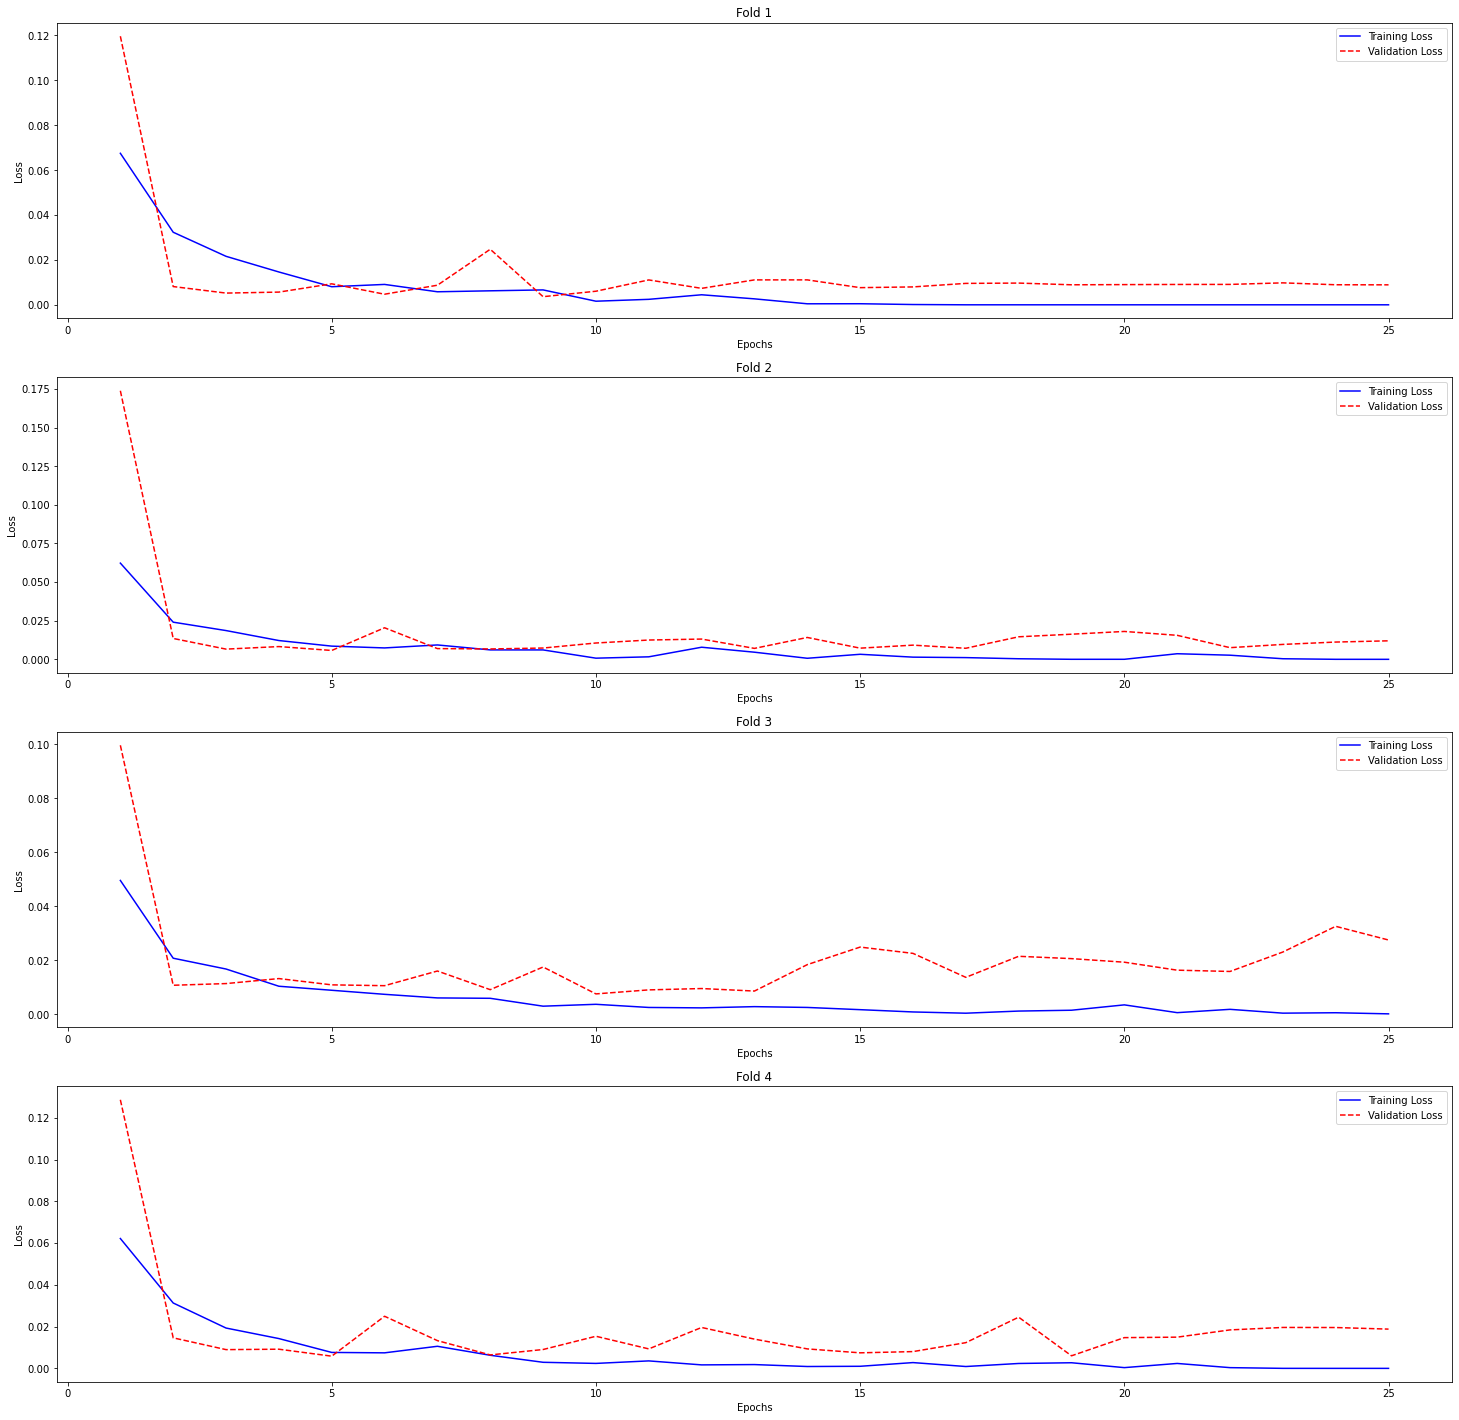

In [16]:
LPV = []
LPT = []
for i in range(len(LP)):
  LPT.append(LP[i]["train"])
  LPV.append(LP[i]["valid"])

xAxis = [i+1 for i in range(cfg.epochs)]

plt.figure(figsize=(25, 25))
plt.subplot(4, 1, 1)
plt.plot(xAxis, LPT[:cfg.epochs], "b", label="Training Loss")
plt.plot(xAxis, LPV[:cfg.epochs], "r--", label="Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Fold 1")
plt.subplot(4, 1, 2)
plt.plot(xAxis, LPT[1*cfg.epochs:2*cfg.epochs], "b", label="Training Loss")
plt.plot(xAxis, LPV[1*cfg.epochs:2*cfg.epochs], "r--", label="Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Fold 2")
plt.subplot(4, 1, 3)
plt.plot(xAxis, LPT[2*cfg.epochs:3*cfg.epochs], "b", label="Training Loss")
plt.plot(xAxis, LPV[2*cfg.epochs:3*cfg.epochs], "r--", label="Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Fold 3")
plt.subplot(4, 1, 4)
plt.plot(xAxis, LPT[3*cfg.epochs:4*cfg.epochs], "b", label="Training Loss")
plt.plot(xAxis, LPV[3*cfg.epochs:4*cfg.epochs], "r--", label="Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Fold 4")
plt.show()

In [17]:
ts_data_setup = DS(ts_images, ts_labels.reshape(-1,1))
ts_data = DL(ts_data_setup, batch_size=cfg.ts_batch_size, shuffle=False)

y_pred = eval_fn(Network, Names, ts_data)

breaker()
print("ANN Model Accuracy  : {:.5f} %".format(accuracy_score(ts_labels, y_pred) * 100))
breaker()


------------------------------

ANN Model Accuracy  : 83.17308 %

------------------------------



In [18]:
breaker()
print("Time taken to run Notebook : {:.2f} minutes".format((time()-notebook_start_time)/60))
breaker()

#Only Uncomment When Committing


------------------------------

Time taken to run Notebook : 7.97 minutes

------------------------------

